In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

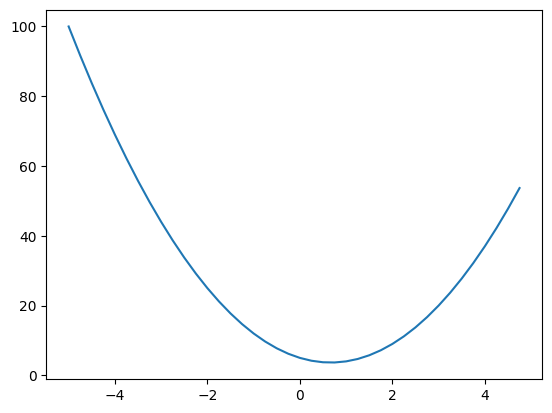

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
# Now the derivative at a particular point
# from the definition of derivate
h = 0.00000001   # lim h->0
x = 3

f(x+h)  # it should be greater than f(x)

# Now Slope

slope = (f(x+h) - f(x)) / h
slope


14.00000009255109

In [6]:
h = 0.00000001   # lim h->0
x = -3

f(x+h)  # it should be greater than f(x)

# Now Slope

slope = (f(x+h) - f(x)) / h
slope   # here it will be negative

-22.00000039920269

In [7]:
h = 0.00000001   # lim h->0
x = 2/3

f(x+h)  # it should be greater than f(x)

# Now Slope

slope = (f(x+h) - f(x)) / h
slope   # here it will be zero

0.0

In [8]:
# Now more complex function
a = 2.0
b = -3.0
c = 10.0

d = a*b + c
print(d)

4.0


In [9]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b +c

a += h  # increment a by h
d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [10]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b +c

b += h  # increment b by h
d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2-d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [11]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b +c

c += h  # increment c by h
d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


## Value() Object Building

In [12]:
class Value:

    def __init__(self, data):
        self.data = data
    
    def __repr__(self):
        return f"Value(data={self.data})"


In [13]:
a = Value(2.0)
a

Value(data=2.0)

In [14]:
# # Now we want to add 2 value objects
# a = Value(2.0)
# b = Value(-3.0)
# c = a + b   # This operating is not defined yet
# c

In [15]:
class Value:

    def __init__(self, data, _children=(), _op=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), "+")

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), "*")

In [16]:
# Now we want to add 2 value objects
a = Value(2.0)
b = Value(-3.0)
c = a + b   # This operating is not defined yet
c

# a +b 
# python will do
# a.__add__(b)

Value(data=-1.0)

In [17]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d = a*b +c  # (a.__mul__(b)).__add__(c)
d

Value(data=4.0)

In [18]:
# We want to keep a track of relationship between a, b, c, d
d._prev # we know the children of the value

{Value(data=-6.0), Value(data=10.0)}

In [19]:
# Now we also want to know what operations created them
d._op

'+'

##### These expressions will get very large, we would like to visualise them with this code

In [20]:
#!pip install graphviz
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [21]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0     # grad represents the derrivative of output (say L) wrt to value (say a or f)
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), "+")

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), "*")

In [22]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b; e.label="e"
d = e+c; d.label="d"
f = Value(-2.0, label="f")
L = d*f; L.label="L"
L

Value(data=-8.0)

## Backpropagation

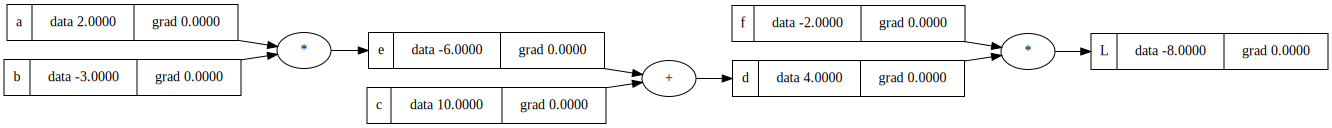

In [23]:
# using this we can visulize the operations
draw_dot(L)

##### Now let's calculate gradients

In [24]:
def lol():
    h = 0.001
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label="e"
    d = e+c; d.label="d"
    f = Value(-2.0, label="f")
    L = d*f; L.label="L"
    L1 = L.data

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label="e"
    d = e+c; d.label="d"
    d.data += h

    f = Value(-2.0, label="f")
    L = d*f; L.label="L"

    L2 = L.data #+ h

    print((L2-L1)/h)
  
lol()

-2.000000000000668


In [25]:
L.grad = 1.0

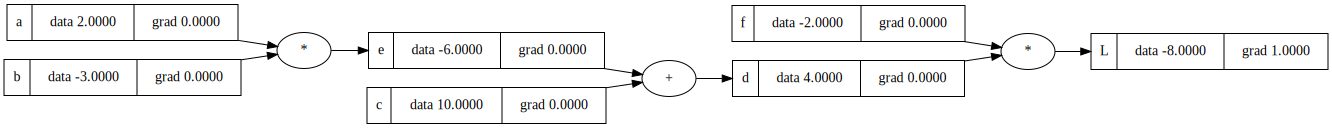

In [26]:
# using this we can visulize the operations
draw_dot(L)

L = d*f

We want to know

dL/dd = ? => f

(f(x+h) - f(x)) / h

proof:
(f(x+h) - f(x)) / h

((d+h)*f - d*f) / h

(d*f + h*f - d*f) / h

h*f / h

= f





In [27]:
f.grad = 4.0    # value of d
d.grad = -2.0    # value of f

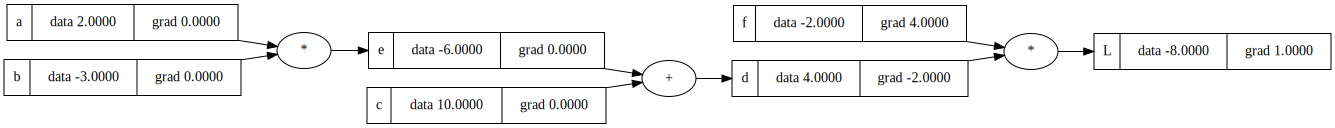

In [28]:
draw_dot(L)

In [29]:
def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0+h, label='b')
  c = Value(10.0, label='c')
  
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  
  L2 = L.data
  
  print((L2 - L1)/h)
  
lol()

-3.9999999999995595


Now, we would want to find dL/dc

We know d = c + e which when differenciated gives dd/dc = 1.0

also, dd/de = 1.0 too

now, dL/dc can calculated with chain rule

The chain rule may also be expressed in Leibniz's notation. If a variable z depends on the variable y, which itself depends on the variable x (that is, y and z are dependent variables), then z depends on x as well, via the intermediate variable y. In this case, the chain rule is expressed as:


dz/dx = (dz/dy) * (dy/dx)   # relative rate of change 

Now, we want:
dL/dc =

We know:
dL/dd
dd/dc

So, 
dL/dc = (dL/dd) * (dd/dc)

The + node just directly routes the rate of change.

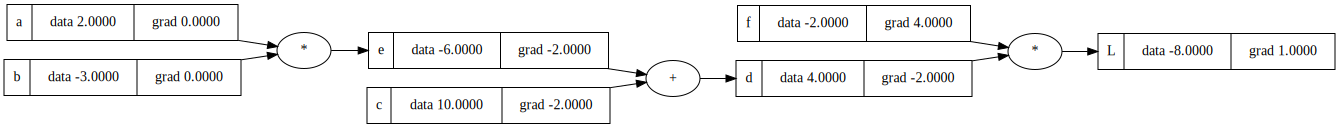

In [30]:
# Therefore:
c.grad = -2.0
e.grad = -2.0
draw_dot(L)

Now we want:

dL/da = (dL/de) * (de/da) 

and

dL/db = dL/de) * (de/db)

e = a*b

de/da = b

de/db = a

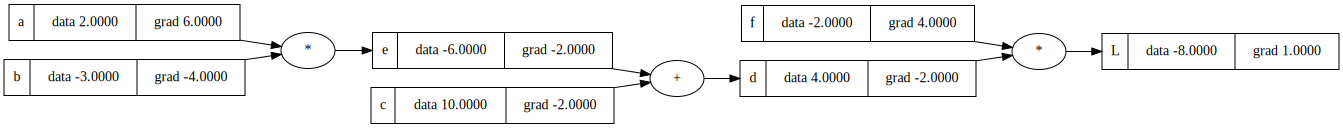

In [31]:
a.grad = (-2.0 * -3.0)
b.grad = (-2.0 * 2.0)
draw_dot(L)

This is exactly what backpropagation is:
Backproagation is recursive application of chain rule throught the computation graph.

#### My own little exercise to see if i really understood everything correctly

In [32]:
a = Value(4.0, label="a")
b = Value(-8.0, label="b")
c = Value(3.0, label="c")
e = a*b; e.label="e"
d = e+c; d.label="d"
f = Value(-5.0, label="f")
L = d*f; L.label="L"
L

Value(data=145.0)

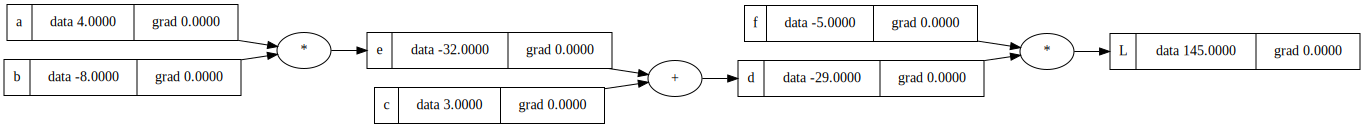

In [33]:
draw_dot(L)

In [34]:
L.grad = 1.0

f.grad = -29.0
d.grad = -5.0

e.grad = -5 * 1
c.grad =  -5 * 1

b.grad = -5 * 4.0
a.grad = -5 * -8.0

# All correct and verified


In [35]:
# verfiying the gradient
def lol():

    h = 0.001

    a = Value(4.0, label="a")
    b = Value(-8.0, label="b")
    c = Value(3.0, label="c")
    e = a*b; e.label="e"
    d = e+c; d.label="d"
    f = Value(-5.0, label="f")
    L = d*f; L.label="L"

    L1 = L.data

    a = Value(4.0 + h, label="a")
    b = Value(-8.0, label="b")
    c = Value(3.0, label="c")
    e = a*b; e.label="e"
    
    d = e+c; d.label="d"
    f = Value(-5.0, label="f")
    L = d*f; L.label="L"
    L2 = L.data

    print((L2 - L1)/h)
  
lol()

40.000000000020464


### Single Optimisation Step

We will nudge our inputs to make L go up

In [36]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b; e.label="e"
d = e+c; d.label="d"
f = Value(-2.0, label="f")
L = d*f; L.label="L"

L.grad = 1.0
f.grad = 4.0    # value of d
d.grad = -2.0    # value of f

c.grad = -2.0
e.grad = -2.0

a.grad = (-2.0 * -3.0)
b.grad = (-2.0 * 2.0)



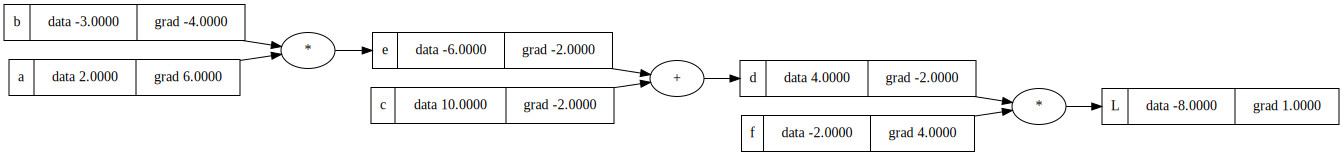

In [37]:
draw_dot(L)

In [38]:
step_size = 0.01

# We are chaning the leaf nodes
a.data += step_size*a.grad
b.data += step_size*b.grad
c.data += step_size*c.grad
f.data += step_size*f.grad

# Let's do the forward pass again
e = a * b
d = e + c
L = d * f

# We expect a greater value of L here
print(L.data)

# This can be used to optimise as we can control the value of L

-7.286496


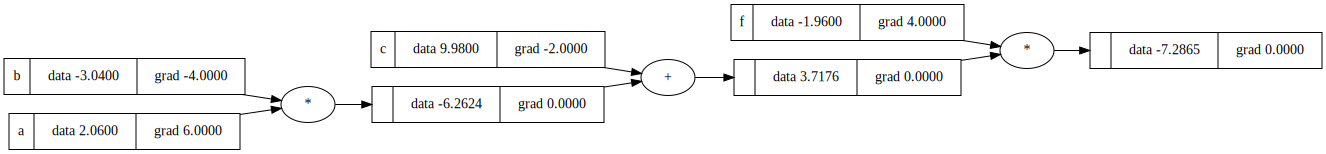

In [39]:
draw_dot(L)

### Manual Backproagation through a Neuron

tanh fucntion, activatiom

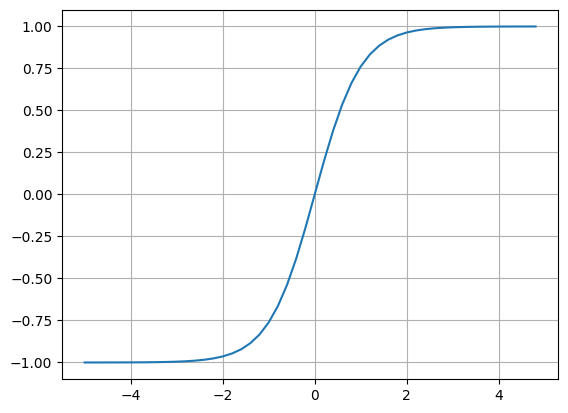

In [40]:
x = np.arange(-5, 5, 0.2)
y = np.tanh(np.arange(-5, 5, 0.2))
plt.plot(x, y)
plt.grid()

# It squashes the input

o = tanh(n)

dervate of tanh = 1 - tanh²

do/dn = 1 - o²


In [41]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0     # grad represents the derrivative of output (say L) wrt to value (say a or f)
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), "+")

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), "*")

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")
        return out

In [42]:
# see neuron_model.jpeg

# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# Weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# Bias of a neuron
b = Value(6.88137358701954432, label="b")

# from figure we can see
# x1*w1 + x2*w2 + b

x1w1 = x1*w1; x1w1.label ="x1*w1"
x2w2 = x2*w2; x2w2.label ="x2*w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b; n.label = "n" # Without activation function now

o = n.tanh(); o.label = "output"

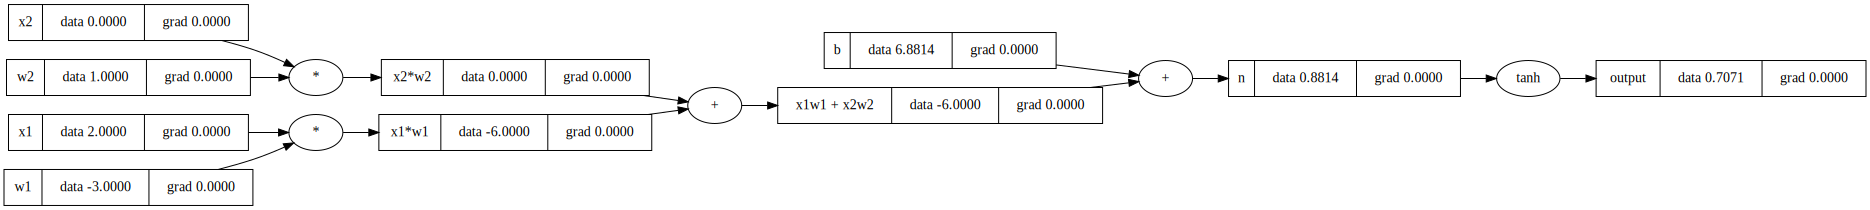

In [43]:
draw_dot(o)

Here we would care more about gradients wrt weights w1 and w2.


Now we calculate gradients

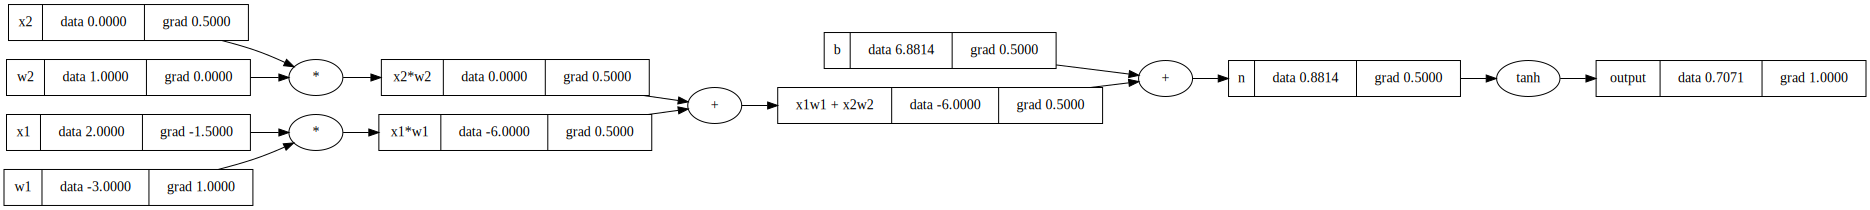

In [44]:
o.grad = 1.0
n.grad = 1 - o.data**2

b.grad = 0.5
x1w1x2w2.grad = 0.5

x1w1.grad = 0.5
x2w2.grad = 0.5

w1.grad = x1w1.grad * x1.data
x1.grad = x1w1.grad * w1.data

w2.grad = x2w2.grad * x2.data
x2.grad = x2w2.grad * w2.data

draw_dot(o)


### Backpropagation function

In [45]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0     # grad represents the derrivative of output (say L) wrt to value (say a or f)
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

            # this means the gradient is just copied as it is as 
            # we have seen it happening for addition            
        
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad          
        
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
            self.grad = (1 - t**2) * out.grad          
        
        out._backward = _backward

        return out 

In [46]:
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# Weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# Bias of a neuron
b = Value(6.88137358701954432, label="b")

# from figure we can see
# x1*w1 + x2*w2 + b

x1w1 = x1*w1; x1w1.label ="x1*w1"
x2w2 = x2*w2; x2w2.label ="x2*w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b; n.label = "n" # Without activation function now

o = n.tanh(); o.label = "output"

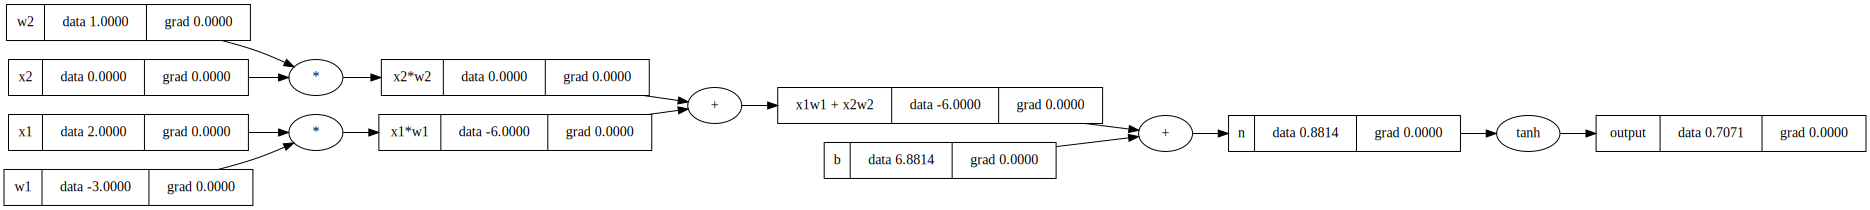

In [47]:
draw_dot(o)

We don't have to do it manually now. We just have to call backward in the right order

In [48]:
# but we will have initialise o.grad first
o.grad = 1.0

In [49]:
o._backward()

In [50]:
n._backward()

In [51]:
b._backward()   # nothing will happen. None

In [52]:
x1w1x2w2._backward()

In [53]:
x1w1._backward()
x2w2._backward()

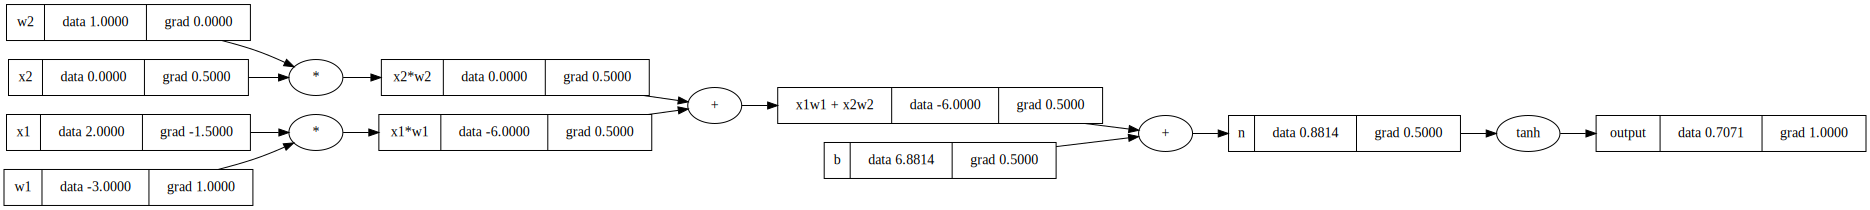

In [54]:
draw_dot(o)

###  Implementing the backward function for a whole expression graph
Now we want to eliminate calling backward pass manually

We want to calculate backward for a node only when backward for all the forward nodes have been calculated.

We calculate backward when backward for all dependencies has been calculated.

This ordering of graphs can be achieved by something called **Toplogical Sort**

In [55]:
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# Weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# Bias of a neuron
b = Value(6.88137358701954432, label="b")

# from figure we can see
# x1*w1 + x2*w2 + b

x1w1 = x1*w1; x1w1.label ="x1*w1"
x2w2 = x2*w2; x2w2.label ="x2*w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b; n.label = "n" # Without activation function now

o = n.tanh(); o.label = "output"

In [56]:
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

In [57]:
o.grad = 1.0

build_topo(o)

for node in reversed(topo):
    node._backward()

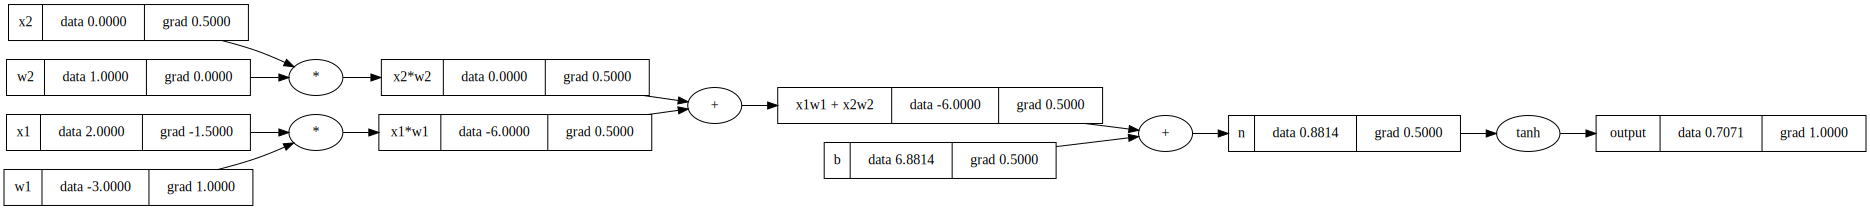

In [58]:
# Here we have it correctly
draw_dot(o)

In [59]:
# Now let's add this to value class

class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0     # grad represents the derrivative of output (say L) wrt to value (say a or f)
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

            # this means the gradient is just copied as it is as 
            # we have seen it happening for addition            
        
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad          
        
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
            self.grad = (1 - t**2) * out.grad          
        
        out._backward = _backward

        return out 

    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [60]:
# Let's see if everything works
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# Weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# Bias of a neuron
b = Value(6.88137358701954432, label="b")

# from figure we can see
# x1*w1 + x2*w2 + b

x1w1 = x1*w1; x1w1.label ="x1*w1"
x2w2 = x2*w2; x2w2.label ="x2*w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b; n.label = "n" # Without activation function now

o = n.tanh(); o.label = "output"

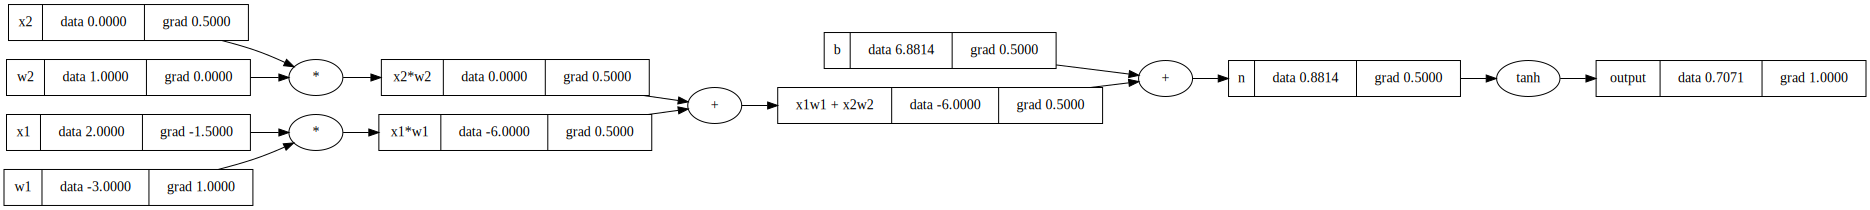

In [61]:
o.backward()

draw_dot(o)

### Now that's backprop for 1 Neuron

There is still a bug, we haven't surfaced yet

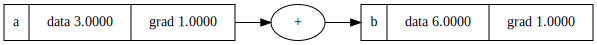

In [62]:
a = Value(3.0, label="a")
b = a + a; b.label="b"

b.backward()

draw_dot(b)


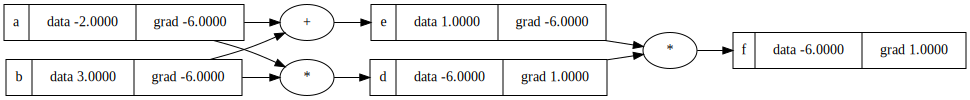

In [63]:
# Another example for this bug
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

# There will be an issue when we are using same variable twice
# before we were using one variable once

# If you see the multivariate chain rule you will see we need to accumulate the gradients
# That's what we will do now
# Any contrubution that flows backward will simply add

In [64]:
# Now let's add this to value class

class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0     # grad represents the derrivative of output (say L) wrt to value (say a or f)
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

            # this means the gradient is just copied as it is as 
            # we have seen it happening for addition            
        
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad          
        
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad          
        
        out._backward = _backward

        return out 

    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


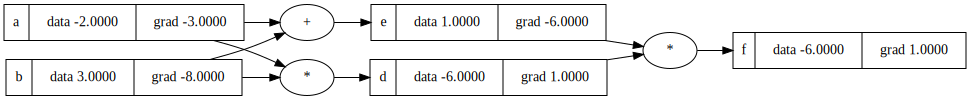

In [65]:
# Another example for this bug
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

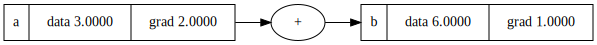

In [66]:
a = Value(3.0, label="a")
b = a + a; b.label="b"

b.backward()

draw_dot(b)


#### Now everything is correct